# Creating Data Subsets
Here we will create subsets of data that can be passed into a multivariate time series regression

In [67]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
from copy import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [68]:
sales = pd.read_csv("../data/raw/sales.csv", header=0, delimiter=",")
sku = pd.read_csv("../data/raw/sku.csv", header=0, delimiter=",")
geoParams = pd.read_csv("../data/raw/geo_params.csv", header=0, delimiter=",")

Merge the geo_params and sales data files. A different subset will be generated for each item (SKU) for every geographic cluster location. The data will be stored in a dictionary with:
- key: `geoCluster_ID` and `SKU`
- value: list of `date`, `price`, and `sales`

The dictionary will be written to a json file for convenience.

### Pre-process sku file

In [69]:
sku.keys()

Index(['SKU', 'Category', 'Type', 'brandId', 'lagerUnitQuantity', 'Units',
       'trademark', 'countryOfOrigin', 'Group'],
      dtype='object')

In [70]:
sku.loc[sku['SKU'].isin( [612845, 782787, 802382, 819149, 819150] ), "Category"] = "Yoghurts"

In [71]:
# Join datasets
sales.sort_values("date", inplace=True)
sales = sales.join(geoParams.set_index("geoCluster"),on="geoCluster", rsuffix="gC")
sales = pd.merge(sales, sku, how='left', on='SKU')

#### Clean Dataset

In [72]:
sales["qty"] = sales.sales
sales = sales.drop(labels='sales', axis='columns')

In [73]:
sales = sales[["date", "SKU", "Category", "geoCluster", "Group", "price", "qty"]]

In [74]:
df_nts = copy( sales )
df_nts['qty'] = df_nts['qty'].fillna(0)
average_price_impute = df_nts[["SKU","price"]].groupby('SKU').mean()
average_price_impute = average_price_impute["price"].to_dict()
average_price_impute[24]
# print(df_nts.loc[(df_nts["SKU"] == sku & pd.isnull(df_nts["price"]), "price")])


# df_nts['price'] = np.where(df_nts['SKU'] == sku, average_price_impute,20)

for sku in df_nts["SKU"].unique():
    # print(average_price_impute[average_price_impute["SKU"]==sku])
    df_nts.loc[ (df_nts["SKU"] == sku) & (pd.isnull(df_nts["price"])) , "price"] = average_price_impute[sku]

df_nts
#     df_nts.loc[(df_nts["SKU"] == sku & pd.isnull(df_nts["price"]), "price").all(1)] = average_price_impute["SKU"]
# df_nts[pd.isnull(df_nts["price"])] = df_nts["SKU"].map(average_price_impute)

,date,SKU,Category,geoCluster,Group,price,qty
0,2020-01-01,49207,Mango,2709,Tropical fruits,36.331031,0.0
1,2020-01-01,690818,"Ciabatta, light, plain, parbaking",2709,Bakery,25.053427,0.0
2,2020-01-01,642700,Semi-hard coarse-pored cheese,3095,Cheese,269.068564,0.0
3,2020-01-01,736360,Yoghurts,2221,Yogurts,22.285024,0.0
4,2020-01-01,20872,"Water, sparkling",2145,Mineral water,37.397197,0.0
...,...,...,...,...,...,...,...
4605980,2021-07-05,49450,Semi-hard bulk cheese,2108,Cheese,286.902627,0.0
4605981,2021-07-05,47330,Semi-hard coarse-pored cheese,2108,Cheese,317.921482,0.0
4605982,2021-07-05,26194,Semi-hard coarse-pored cheese,2108,Cheese,353.384395,0.0
4605983,2021-07-05,571255,Semi-hard coarse-pored cheese,2112,Cheese,317.092701,0.0


In [75]:
df_nts = copy( sales )
df_nts = df_nts.dropna()

# Later ToDo where price is 0 fix it.
df_nts = df_nts.drop(df_nts[df_nts['price'] == 0].index, axis=0)


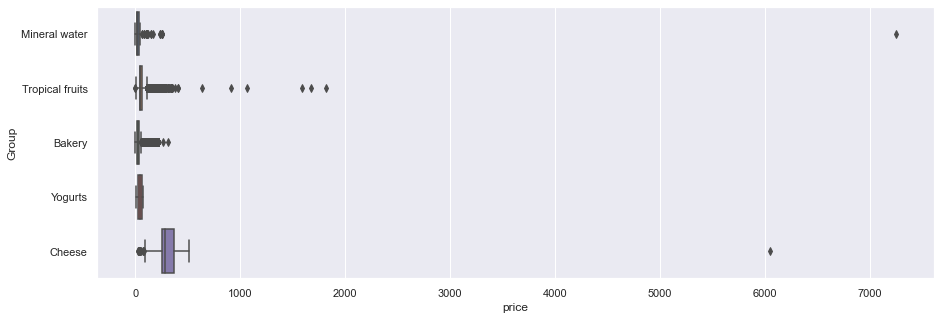

In [76]:
# boxplot_data = df_nts[np.intersect1d(df_nts.columns, ["price", "qty"])]
# sns.boxplot(data=boxplot_data)
sns.set(rc = {'figure.figsize':(15,5)})
ax = sns.boxplot(x="price", y="Group", data=df_nts, orient="h")

In [77]:
df_nts_out_floor_cap = df_nts
df_nts_outliers = df_nts["price"]

df_nts_bottom = df_nts_outliers.quantile(0.10)
df_nts_top = df_nts_outliers.quantile(0.90)

df_nts_out_floor_cap = df_nts_outliers[~((df_nts_outliers < df_nts_bottom) | (df_nts_outliers > df_nts_top))]
print((len(df_nts)-len(df_nts_out_floor_cap))/len(df_nts))

0.19384321425310944


In [78]:
df_nts_out_IQR = df_nts
df_nts_outliers = df_nts["price"]

Q1 = df_nts_outliers.quantile(0.25)
Q3 = df_nts_outliers.quantile(0.75)
IQR = Q3 - Q1

print(f'The lower IQR is: {Q1 - 1.5 * IQR}')
# lower IQR is negative, and the lower bound of price is €0.09. We will not adjust this as it is reasonable given the products.

df_nts_out_IQR = df_nts_outliers[(df_nts_outliers < (Q3 + 1.5 * IQR))]
print((len(df_nts)-len(df_nts_out_IQR))*100/len(df_nts))
df_nts_outliers.describe()
# 11.6% data being dropped with 1.5*IQR outlier drop method.

The lower IQR is: -32.50999999999999
11.559821064637122


count    777711.000000
mean         67.547508
std          85.645251
min           0.090000
25%          24.190000
50%          38.790000
75%          61.990000
max        7246.890000
Name: price, dtype: float64

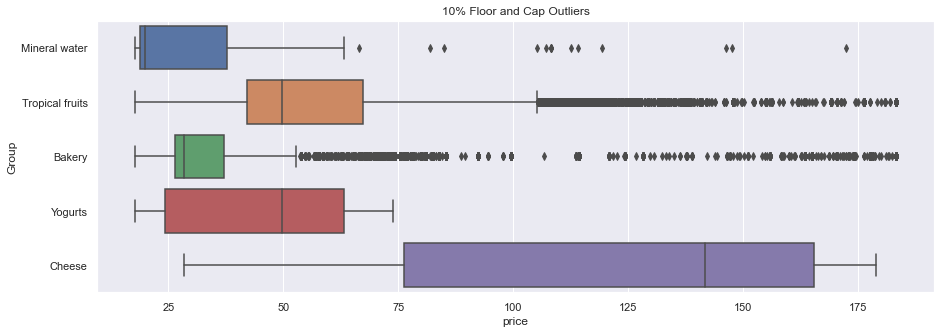

In [79]:
ax = sns.boxplot(x="price", y="Group", data=df_nts.loc[df_nts_out_floor_cap.index, :], orient="h").set(title='10% Floor and Cap Outliers')

In [80]:
# new values of data after outliers removal and cleaning
df_nts.loc[df_nts_out_IQR.index, :].describe()

,SKU,geoCluster,price,qty
count,687809.000000,687809.000000,687809.000000,687809.000000
mean,316301.388877,2229.782924,39.577727,3.977670
std,299283.237084,268.399299,21.236998,4.785672
min,24.000000,92.000000,0.090000,0.001000
25%,32546.000000,2041.000000,21.390000,2.000000
50%,219149.000000,2131.000000,36.690000,3.000000
75%,596031.000000,2279.000000,49.790000,5.000000
max,838137.000000,3230.000000,118.590000,801.000000


In [81]:
# previous values of data before outliers removal and cleaning (for comparison)
df_nts.describe()

,SKU,geoCluster,price,qty
count,777711.000000,777711.000000,777711.000000,777711.000000
mean,317536.134199,2230.152414,67.547508,3.594929
std,295439.526654,268.915895,85.645251,4.628539
min,24.000000,92.000000,0.090000,0.001000
25%,32546.000000,2041.000000,24.190000,1.000000
50%,219149.000000,2129.000000,38.790000,2.500000
75%,591899.000000,2279.000000,61.990000,4.000000
max,838137.000000,3230.000000,7246.890000,801.000000


In [82]:
df_nts[df_nts["qty"]>50]


,date,SKU,Category,geoCluster,Group,price,qty
782,2020-04-04,32485,Banana,2154,Tropical fruits,39.79,78.22
795,2020-04-04,32485,Banana,2134,Tropical fruits,39.79,64.35
802,2020-04-04,32485,Banana,2481,Tropical fruits,36.99,65.35
840,2020-04-04,32485,Banana,2143,Tropical fruits,39.79,53.48
858,2020-04-04,32485,Banana,2746,Tropical fruits,40.69,142.57
...,...,...,...,...,...,...,...
4583056,2021-07-04,16649,"Water, still",2001,Mineral water,17.39,88.00
4593780,2021-07-05,16649,"Water, still",2021,Mineral water,17.39,106.00
4593942,2021-07-05,16649,"Water, still",2001,Mineral water,17.39,51.00
4594175,2021-07-05,39465,"Water, slightly sparkling",2086,Mineral water,17.39,61.00


In [83]:

df_nts = df_nts.loc[df_nts_out_IQR.index, :]
df_nts.to_csv("../data/processed/nts_imputed_v3.csv", index=False)

In [84]:
# ---------- Testing ----------
# df_temp = df_nts[df_nts["price"] == 0]
# df_temp.to_csv("temp.csv", index=False)
#df_nts.describe(include='all')